In [1]:
import glob
import os
import pickle
import pprint
from datetime import datetime
from pathlib import Path

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pytz
import seaborn as sns
from omegaconf import OmegaConf
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
pl.Config.set_fmt_str_lengths(100)


exp_number: '003'
run_time: base
data:
  input_root: ../../data/input
  train_path: ../../data/input/train_features.csv
  test_path: ../../data/input/test_features.csv
  sample_submission_path: ../../data/input/sample_submission.csv
  output_root: ../../data/output
  results_root: ../../results
  results_path: ../../results/003/base
seed: 319
n_splits: 5
target_cols:
- x_0
- y_0
- z_0
- x_1
- y_1
- z_1
- x_2
- y_2
- z_2
- x_3
- y_3
- z_3
- x_4
- y_4
- z_4
- x_5
- y_5
- z_5
lgb:
  params:
    objective: regression_l1
    metric: mae
    verbosity: -1
    boosting_type: gbdt
    learning_rate: 0.01
    num_leaves: 31
    min_child_samples: 20
    max_depth: -1
    subsample_freq: 0
    bagging_seed: 0
    feature_fraction: 0.9
    bagging_fraction: 0.9
    bagging_freq: 1
    reg_alpha: 0.1
    reg_lambda: 0.1
  early_stopping_rounds: 100
  log_evaluation_period: 500
  num_boost_round: 100000



/Users/marumarukun/Documents/compe/atmacup_18/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


polars.config.Config

### exp003

- NNモデルで作成したoofを特徴量としてlightgbmするnotebook(スタッキングのイメージ)
- 特徴量エンジニアリングも行う

### データの読み込み

In [2]:
# データの読み込み
train = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
sample_submission = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)

# 前処理

# 元のindexを作成（学習、推論前に元の順序情報を復元するため）
train = train.with_columns(pl.col("ID").cum_count().alias("index"))
test = test.with_columns(pl.col("ID").cum_count().alias("index"))

# bool型をint8に変換
train = train.with_columns(train.select(pl.col(pl.Boolean).cast(pl.Int8)))
test = test.with_columns(test.select(pl.col(pl.Boolean).cast(pl.Int8)))

# scene列を作成 → これでGroupKFoldする
train = train.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))
test = test.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))

# decisecond列を作成
train = train.with_columns(pl.col("ID").str.split("_").list[1].cast(pl.Int32).alias("decisecond"))
test = test.with_columns(pl.col("ID").str.split("_").list[1].cast(pl.Int32).alias("decisecond"))

# trainとtestを結合する（ラベルエンコーディング用）
train_test = pl.concat([train, test], how="diagonal")

# CV
gkf = GroupKFold(n_splits=cfg.n_splits)


In [3]:
# exp002のoofとpredictionsを特徴量として追加(train, testのデータの順序が変わっていないか注意)
oof = np.load("../002/oof_predictions.npy")
predictions = np.load("../002/final_predictions.npy")

# trainにoofを追加
exprs = [pl.Series(oof[:, i]).alias(f"nn_{cfg.target_cols[i]}") for i in range(len(cfg.target_cols))]
train = train.with_columns(exprs)

# testにpredictionsを追加
exprs = [pl.Series(predictions[:, i]).alias(f"nn_{cfg.target_cols[i]}") for i in range(len(cfg.target_cols))]
test = test.with_columns(exprs)


In [4]:
# gearShifterのラベルエンコーディング
le = LabelEncoder()
le.fit(train_test["gearShifter"].fill_null(""))
train = train.with_columns(
    pl.Series(le.transform(train["gearShifter"].fill_null(""))).cast(pl.Int16).alias("gearShifter")
)
test = test.with_columns(pl.Series(le.transform(test["gearShifter"].fill_null(""))).cast(pl.Int16).alias("gearShifter"))
train_test = pl.concat([train, test], how="diagonal")


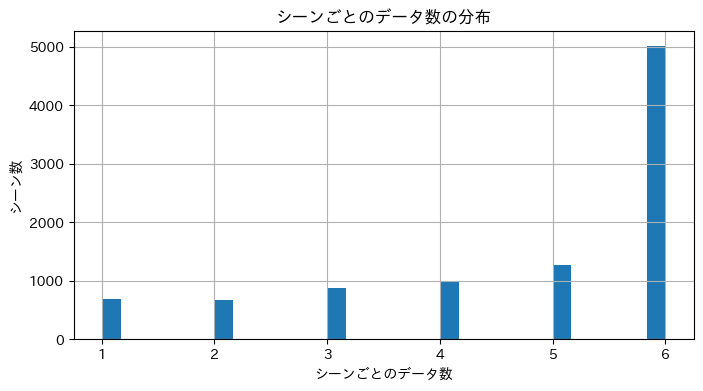

In [5]:
# シーンごとのデータ数の分布 → 多くのシーンが3以上あるので2個前後の値の特徴量があってもいいと思う
data = train_test.group_by("scene").agg(pl.len()).get_column("len")
plt.figure(figsize=(8, 4))
plt.hist(data, bins=30)
plt.xlabel("シーンごとのデータ数")
plt.ylabel("シーン数")
plt.title("シーンごとのデータ数の分布")
plt.grid(True)
plt.show()


In [6]:
# 同一シーンからの集約特徴量作成

agg_cols = ["vEgo", "aEgo", "steeringAngleDeg", "steeringTorque", "gas"]
bool_cols = ["brakePressed", "gasPressed", "leftBlinker", "rightBlinker"]
cat_cols = ["gearShifter"]

exprs = []
exprs += [
    pl.col(agg_col).shift(-2).over("scene").alias(f"{agg_col}_shift-2") for agg_col in agg_cols + bool_cols + cat_cols
]  # 2ステップ前の時間の値
exprs += [
    pl.col(agg_col).shift(2).over("scene").alias(f"{agg_col}_shift2") for agg_col in agg_cols + bool_cols + cat_cols
]  # 2ステップ後の時間の値
exprs += [
    pl.col(agg_col).shift(-1).over("scene").alias(f"{agg_col}_shift-1") for agg_col in agg_cols + bool_cols + cat_cols
]  # 1ステップ前の時間の値
exprs += [
    pl.col(agg_col).shift(1).over("scene").alias(f"{agg_col}_shift1") for agg_col in agg_cols + bool_cols + cat_cols
]  # 1ステップ後の時間の値
exprs += [
    pl.col(agg_col).diff(-1).over("scene").alias(f"{agg_col}_diff-1") for agg_col in agg_cols + bool_cols
]  # 1ステップ前の時間の値との差分
exprs += [
    pl.col(agg_col).diff(1).over("scene").alias(f"{agg_col}_diff1") for agg_col in agg_cols + bool_cols
]  # 1ステップ後の時間の値との差分
exprs += [pl.col(agg_col).mean().over("scene").alias(f"{agg_col}_mean") for agg_col in agg_cols]  # 同一シーンの平均値
exprs += [pl.col(agg_col).std().over("scene").alias(f"{agg_col}_std") for agg_col in agg_cols]  # 同一シーンの標準偏差
exprs += [pl.col(agg_col).max().over("scene").alias(f"{agg_col}_max") for agg_col in agg_cols]  # 同一シーンの最大値
exprs += [pl.col(agg_col).min().over("scene").alias(f"{agg_col}_min") for agg_col in agg_cols]  # 同一シーンの最小値

# train_test = train_test.sort(
#     # shiftと diffが時系列順に並んでいる必要があるためシーンごとに時間軸でソート
#     "scene",
#     "decisecond",
# ).with_columns(exprs)
train = train.sort("scene", "decisecond").with_columns(exprs)
test = test.sort("scene", "decisecond").with_columns(exprs)


In [7]:
# 信号機情報
traffic_lights_dfs = []

# 信号機情報が入っているjsonファイルを1件ずつ読み込む
for f in tqdm(glob.glob("../../data/input/traffic_lights/*"), smoothing=True):
    if os.path.getsize(f) < 3:
        # ファイルサイズが3未満（からのファイル）の場合はスキップ
        # からのファイルはおそらく信号機が映っていない or 検出できなかったものと思われる
        continue
    data_id = f.split("/")[-1].split(".")[0]
    # jsonを読み込みフォルダ名からIDカラムを作成
    traffic_lights_dfs.append(pl.read_json(f).with_columns(pl.lit(data_id).alias("ID")))

# jsonから作成した個別のDataFrameを結合
traffic_lights_df = pl.concat(traffic_lights_dfs, how="vertical")
# bboxがListになっているので列に展開
bbox_df = traffic_lights_df["bbox"].list.to_struct(fields=[f"bbox_{i}" for i in range(4)]).struct.unnest()
traffic_lights_df = pl.concat([traffic_lights_df, bbox_df], how="horizontal").select(pl.all().exclude("bbox"))
traffic_lights_df


100%|██████████| 45098/45098 [00:01<00:00, 42201.30it/s]


index,class,ID,bbox_0,bbox_1,bbox_2,bbox_3
i64,str,str,f64,f64,f64,f64
1,"""green""","""09d06d87af38504e4acb516d00701b9e_420""",79.75589,3.202439,83.10009,4.819269
1,"""empty""","""046c0c4c07a251e27970ce1e50d5d5db_220""",67.630104,1.405671,71.305466,3.170786
1,"""green""","""3439926752c1474159ed4f6b8e6cc5d6_520""",120.975266,2.085613,124.532082,3.740852
1,"""green""","""46d9bbbe8f280d143d2c7c0e1c0e8ef7_120""",57.987415,7.165268,60.647766,8.429379
2,"""green""","""46d9bbbe8f280d143d2c7c0e1c0e8ef7_120""",75.74295,8.871066,78.087456,10.026294
…,…,…,…,…,…,…
1,"""red""","""c0f79b7f3066180ae3022efb9d6ef496_520""",42.711899,2.543556,44.801765,4.044503
2,"""red""","""c0f79b7f3066180ae3022efb9d6ef496_520""",20.609226,3.412901,22.770834,4.828687
3,"""right""","""c0f79b7f3066180ae3022efb9d6ef496_520""",42.714893,2.544625,44.809673,4.04133


In [8]:
# classの数を集計
traffic_lights_class_count_df = traffic_lights_df.pivot(
    values="class", index="ID", on="class", aggregate_function="len"
).fill_null(0)
traffic_lights_class_count_df


ID,green,empty,red,straight,yellow,right,left,other
str,u32,u32,u32,u32,u32,u32,u32,u32
"""09d06d87af38504e4acb516d00701b9e_420""",1,0,0,0,0,0,0,0
"""046c0c4c07a251e27970ce1e50d5d5db_220""",0,1,0,0,0,0,0,0
"""3439926752c1474159ed4f6b8e6cc5d6_520""",1,0,0,0,0,0,0,0
"""46d9bbbe8f280d143d2c7c0e1c0e8ef7_120""",3,0,0,0,0,0,0,0
"""17360ed6802ca3a56391ec264b4aa649_520""",0,0,1,0,0,0,0,0
…,…,…,…,…,…,…,…,…
"""1b1f08119516920cf1de3134cf34f5a7_20""",2,0,0,0,0,0,0,0
"""916f3ff96524aa35ecd35796f30a1081_520""",0,0,3,0,0,0,0,0
"""273c5c33083527b7ee4f88e9deb5294f_120""",0,0,1,0,0,0,0,0


In [9]:
# 信号機情報をtrainとtestに追加
train = train.join(traffic_lights_class_count_df, how="left", on="ID")
test = test.join(traffic_lights_class_count_df, how="left", on="ID")


In [10]:
# 元の順序に戻す
train = train.sort("index")
test = test.sort("index")


In [11]:
print(len(train.columns), len(test.columns))


137 119


In [12]:
train.head()


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,index,scene,decisecond,nn_x_0,nn_y_0,nn_z_0,nn_x_1,…,vEgo_diff1,aEgo_diff1,steeringAngleDeg_diff1,steeringTorque_diff1,gas_diff1,brakePressed_diff1,gasPressed_diff1,leftBlinker_diff1,rightBlinker_diff1,vEgo_mean,aEgo_mean,steeringAngleDeg_mean,steeringTorque_mean,gas_mean,vEgo_std,aEgo_std,steeringAngleDeg_std,steeringTorque_std,gas_std,vEgo_max,aEgo_max,steeringAngleDeg_max,steeringTorque_max,gas_max,vEgo_min,aEgo_min,steeringAngleDeg_min,steeringTorque_min,gas_min,green,empty,red,straight,yellow,right,left,other
str,f64,f64,f64,f64,f64,i8,f64,i8,i16,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,str,i32,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32,u32,u32,u32,u32,u32
"""00066be8e20318869c38c66be466631a_320""",5.701526,1.538456,-2.165777,-139.0,0.0,0,0.25,1,0,0,0,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,1,"""00066be8e20318869c38c66be466631a""",320,3.235696,-0.016541,0.008176,6.966663,…,null,null,null,null,null,null,null,null,null,9.116789,0.683145,-5.592193,-105.0,0.143333,2.978562,0.741122,5.241203,52.943366,0.12897,11.176292,1.538456,-2.165777,-44.0,0.25,5.701526,0.231099,-11.625697,-139.0,0.0,null,null,null,null,null,null,null,null
"""00066be8e20318869c38c66be466631a_420""",11.176292,0.279881,-11.625697,-44.0,0.0,0,0.0,0,0,0,1,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,2,"""00066be8e20318869c38c66be466631a""",420,2.927237,-0.129783,0.002751,6.2365,…,5.474767,-1.258575,-9.45992,95.0,-0.25,0,-1,0,1,9.116789,0.683145,-5.592193,-105.0,0.143333,2.978562,0.741122,5.241203,52.943366,0.12897,11.176292,1.538456,-2.165777,-44.0,0.25,5.701526,0.231099,-11.625697,-139.0,0.0,null,null,null,null,null,null,null,null
"""00066be8e20318869c38c66be466631a_520""",10.472548,0.231099,-2.985105,-132.0,0.0,0,0.18,1,0,0,0,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,3,"""00066be8e20318869c38c66be466631a""",520,4.510183,-0.015305,-0.003629,9.309396,…,-0.703744,-0.048782,8.640593,-88.0,0.18,0,1,0,-1,9.116789,0.683145,-5.592193,-105.0,0.143333,2.978562,0.741122,5.241203,52.943366,0.12897,11.176292,1.538456,-2.165777,-44.0,0.25,5.701526,0.231099,-11.625697,-139.0,0.0,null,null,null,null,null,null,null,null
"""000fb056f97572d384bae4f5fc1e0f28_120""",6.055565,-0.117775,7.632668,173.0,0.0,0,0.0,0,0,0,0,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,4,"""000fb056f97572d384bae4f5fc1e0f28""",120,3.336447,0.001536,0.005797,6.940908,…,2.738821,-1.394509,39.358145,287.0,-0.255,0,-1,0,0,7.385787,0.370426,-4.879288,-39.666667,0.1175,2.286833,0.485793,14.086582,124.456686,0.082629,9.09602,1.276733,7.632668,173.0,0.255,3.316744,-0.117775,-31.725477,-133.0,0.0,null,null,null,null,null,null,null,null
"""000fb056f97572d384bae4f5fc1e0f28_20""",3.316744,1.276733,-31.725477,-114.0,0.0,0,0.255,1,0,0,0,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243,5,"""000fb056f97572d384bae4f5fc1e0f28""",20,1.815913,-0.021141,0.003853,4.027243,…,null,null,null,null,null,null,null,null,null,7.385787,0.370426,-4.879288,-39.666667,0.1175,2.286833,0.485793,14.086582,124.456686,0.082629,9.09602,1.276733,7.632668,173.0,0.255,3.316744,-0.117775,-31.725477,-133.0,0.0,1,0,0,0,0,0,0,0


In [13]:
del_cols = ["ID", "scene", "decisecond", "index"] + cfg.target_cols
use_cols = list(set(train.columns) - set(del_cols))
use_cols.sort()

group_cols = ["scene"]


In [14]:
x_train = train.select(use_cols).to_pandas()
group = train.select(group_cols).to_pandas()
x_test = test.select(use_cols).to_pandas()


### 学習

In [15]:
# 学習関数
def lgb_cv_train(x_train, y_train, group):
    # 学習設定
    lgb_data = lgb.Dataset(
        x_train,
        label=y_train,
        # categorical_feature=cfg.categorical_features,
    )
    callbacks = [
        lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
        lgb.log_evaluation(cfg.lgb.log_evaluation_period),
    ]

    # 学習
    cv_results = lgb.cv(
        dict(cfg.lgb.params),
        lgb_data,
        folds=gkf.split(x_train, y_train, group),
        num_boost_round=cfg.lgb.num_boost_round,
        callbacks=callbacks,
        return_cvbooster=True,
        seed=cfg.seed,
    )

    return cv_results


# log 関数
def log_cv_results(cv_results, target_col):
    cvbooster = cv_results["cvbooster"]
    best_iteration = cvbooster.best_iteration
    best_score = cv_results["valid l1-mean"][best_iteration - 1]
    best_score_stdv = cv_results["valid l1-stdv"][best_iteration - 1]

    with open(f"{cfg.data.results_path}/{target_col}/log.txt", "w") as log_file:
        log_file.write("====== CV Score ======\n")
        log_file.write(f"best_iteration: {best_iteration}\n")
        log_file.write(f"best_score: {best_score}\n")
        log_file.write(f"best_score_stdv: {best_score_stdv}\n")

        log_file.write("\n====== params ======\n")
        log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

        log_file.write("\n====== feature name ======\n")
        log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


In [16]:
# 実験結果格納用のディレクトリを作成
japan_tz = pytz.timezone("Asia/Tokyo")
cfg.run_time = datetime.now(japan_tz).strftime("%Y%m%d_%H%M%S")
create_dir(cfg.data.results_path)

# cv, predsリスト
cv_scores = []
target_preds = []

for target_col in cfg.target_cols:
    print(f"\n\n===== target_col: {target_col} =====\n\n")
    y_train = train.select(target_col).to_pandas()
    # 学習
    cv_results = lgb_cv_train(x_train, y_train, group)

    # 学習モデル保存
    cvbooster = cv_results["cvbooster"]
    create_dir(f"{cfg.data.results_path}/{target_col}")
    with open(f"{cfg.data.results_path}/{target_col}/model.pkl", "wb") as f:
        pickle.dump(cvbooster, f)

    # log
    log_cv_results(cv_results, target_col)

    # CV用のスコアを保存
    best_iteration = cv_results["cvbooster"].best_iteration
    best_score = cv_results["valid l1-mean"][best_iteration - 1]
    cv_scores.append(best_score)

    # テストコードの推論
    x_test = test.select(use_cols).to_pandas()
    y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
    y_pred = np.mean(y_preds, axis=0)
    target_preds.append(y_pred)

# # モデルのロード
# with open(f"{cfg.data.results_path}/model.pkl", "rb") as f:
#     loaded_cvbooster = pickle.load(f)

# cv_score
cv_score = np.mean(cv_scores)
print(f"cv_score: {cv_score}")

# submission
exprs = [pl.Series(target_preds[i]).alias(cfg.target_cols[i]) for i in range(len(cfg.target_cols))]
submission = sample_submission.with_columns(exprs)
submission.write_csv(f"{cfg.data.results_path}/submission.csv")
submission.head()


Directory created: ../../results/003/20241120_165721


===== target_col: x_0 =====


Training until validation scores don't improve for 100 rounds
[500]	cv_agg's valid l1: 0.0786705 + 0.002392
[1000]	cv_agg's valid l1: 0.0639631 + 0.00107062
[1500]	cv_agg's valid l1: 0.0635704 + 0.00108408
[2000]	cv_agg's valid l1: 0.063344 + 0.00107001
[2500]	cv_agg's valid l1: 0.0632056 + 0.00107315
[3000]	cv_agg's valid l1: 0.0630998 + 0.00107107
[3500]	cv_agg's valid l1: 0.0630325 + 0.00106922
[4000]	cv_agg's valid l1: 0.0629835 + 0.00106018
[4500]	cv_agg's valid l1: 0.0629525 + 0.00106555
[5000]	cv_agg's valid l1: 0.0629203 + 0.00105505
[5500]	cv_agg's valid l1: 0.0628957 + 0.00104227
[6000]	cv_agg's valid l1: 0.0628825 + 0.00103892
[6500]	cv_agg's valid l1: 0.0628679 + 0.00104001
Early stopping, best iteration is:
[6648]	cv_agg's valid l1: 0.0628648 + 0.00103742
Directory created: ../../results/003/20241120_165721/x_0


===== target_col: y_0 =====


Training until validation scores don't improve 

x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.50062,-0.033614,-0.002044,3.105847,-0.087787,-0.006099,4.717265,-0.117643,-0.005072,6.184013,-0.087078,-0.009809,7.524869,-0.028387,-0.010037,9.028438,0.043343,-0.013042
1.011067,0.384445,-0.004377,1.973596,0.960645,-0.004688,2.829666,1.87283,-0.007066,3.556385,2.915559,-0.014335,4.127945,3.964083,-0.006343,4.262425,5.276028,0.002907
1.608424,0.007763,-0.00359,3.272386,0.029603,-0.008628,4.767797,0.025208,-0.016014,6.247283,0.028899,-0.019779,7.582581,0.047814,-0.018435,8.858595,0.064154,-0.030552
0.886019,0.074347,0.001283,1.698818,0.17472,0.00415,2.399419,0.375424,0.010236,3.063517,0.628022,0.017576,3.65643,0.913906,0.027272,4.172632,1.190491,0.037027
0.835868,-0.002766,-0.004286,1.50681,-0.004049,-0.010187,1.942255,-0.004201,-0.024557,2.212825,0.002045,-0.034699,2.074117,-0.005792,-0.052132,1.492062,-0.031275,-0.064259
